# Syntax Analysis Demo

In [124]:
import avn.syntax as syntax
import avn.plotting as plotting

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In this tutorial, we will be using the avn.syntax module to analyse and visualize song syntax first from a single bird, then multiple birds at once. This requires that you have labeled syllable data, with the onset timestamp, offset timestamp, file of origin and syllable label for every syllable from a set of recordings for the subject bird. These can be generated either through manual syllable labeling (as in the example data used in this tutorial), or through automated syllable labeling methods (stay tuned for this in a later avn version). 

## Syntax Analysis for a Single Bird

### Creating a SyntaxData Object

Let's begin by loading our labeled syllable data and using it to instantiate a `SyntaxData` type object. This type of object has many built-in functions that will make it easier to process the syllable data. 

Our syllable data should be stored in a dataframe with columns `files`, `onsets`, `offsets` and `labels`, where each row represents a single syllable produced by the bird. 

- `files` should contain the name of the .wav file in which the syllable is found. 
- `onsets` should contain the onset timestamp of the syllable in seconds within the file. 
- `offsets` should contain the offset timestamp of the syllable in seconds within the file.
- `labels` should contain a label for the syllable type. Here we use single characters to denote different syllable types, but you can also use numbers (ints or floats) or words (strings). 

If your syllable dataframe has any additional columns (with notes or alternative labels for example), that is completely fine and those will be preserved, but only syllable labels in the `labels` column will be used for syntax analysis. 

Here is an example of what the syllable dataframe should look like: 

In [125]:
Bird_ID = 'G402'
path_to_syll_df = "../sample_data/" + Bird_ID + "_syll_df.csv"
syll_df = pd.read_csv(path_to_syll_df)
syll_df

,files,onsets,offsets,labels
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i
4,G402_43362.23322048_9_19_6_28_42.wav,0.828390,0.898912,i
...,...,...,...,...
589,G402_43362.43586086_9_19_12_6_26.wav,1.808186,1.976712,b
590,G402_43362.43586086_9_19_12_6_26.wav,2.011905,2.095646,c
591,G402_43362.43586086_9_19_12_6_26.wav,2.114762,2.263175,d
592,G402_43362.43586086_9_19_12_6_26.wav,2.318934,2.402177,e


By passing the Bird_ID and syllable dataframe as inputs to `avn.syntax.SyntaxData()` we create a new `SyntaxData` type object. 

In [126]:
syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

### Pre-processing syllables

Now that we've created our SyntaxData object, we can use it to add file boundaries and gaps to our syll_df, and filter out calls. 

#### Adding File Boundaries



When looking at the sequence of syllables that a bird produces, we want to recognize file boundaries so that we don't count transitions beteween the last syllable of one file and the first syllable of the next. To account for this, we can call the `.add_file_bounds()` method of our `syntax_data` object, which will add rows to the syll_df dataframe representing the beginning and end of each file. This requires that we pass the path to the folder containing all song files so that we can determine the total duration of each file for end of file timestamp.  

In [127]:
syntax_data.add_file_bounds("../sample_data/")
syntax_data.syll_df

,files,onsets,offsets,labels
0,G402_43362.23322048_9_19_6_28_42.wav,0.000000,0.000000,file_start
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i
...,...,...,...,...
590,G402_43362.43586086_9_19_12_6_26.wav,2.011905,2.095646,c
591,G402_43362.43586086_9_19_12_6_26.wav,2.114762,2.263175,d
592,G402_43362.43586086_9_19_12_6_26.wav,2.318934,2.402177,e
593,G402_43362.43586086_9_19_12_6_26.wav,2.433810,2.563447,f


As you can see from the preview of `syntax_data.syll_df` above, new rows with the labels "file_start" and "file_end" have been added to the `syll_df` attribute of the `syntax_data` object. The timestamp associated with file starts is always 0, and the timestamp associated with file ends is the duration of the file in seconds. 

#### Adding Silent Gaps

When looking at transitions between syllables, it is also important to consider whether there are long silent gaps between syllables or between a syllable and a file boundary. By considering long silences as their own syntactially relevant state, we can see which syllables often start or end song bouts (ie follow or preceed long silences), and how variable bout starts and ends are. 

We can add rows reflecting long silent gaps between syllables by calling the `.add_gaps()` method of our `syntax_data` object. By default, this function will add a row to the `syll_df` attribute of `syntax_data` whenever there is a gap longer than 0.2 seconds between the offset of one row and the onset of the next. In my experience, this is a good duration threshold because most gaps between bouts are longer than 0.2 seconds, and most gaps within song bouts are shorter than 0.2 seconds. If you want to use a different cutoff value, simply pass the duration in seconds as the `min_gap` argument to the function. 

In [128]:
syntax_data.add_gaps(min_gap = 0.2)
syntax_data.syll_df

,files,onsets,offsets,labels,durations
0,G402_43362.23322048_9_19_6_28_42.wav,0.000000,0.000000,file_start,NaN
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i,NaN
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i,NaN
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i,NaN
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i,NaN
...,...,...,...,...,...
591,G402_43362.43586086_9_19_12_6_26.wav,2.114762,2.263175,d,NaN
592,G402_43362.43586086_9_19_12_6_26.wav,2.318934,2.402177,e,NaN
593,G402_43362.43586086_9_19_12_6_26.wav,2.433810,2.563447,f,NaN
593,G402_43362.43586086_9_19_12_6_26.wav,2.563447,4.539501,silent_gap,1.976054


If you are interesting in looking at the durations of all gaps between syllables (either to assess the bird's timing or to inform the selection of a `min_gap` duration), you can create a dataframe of all gaps between rows in `syll_df` with `.get_gaps_df()`. 

In [129]:
gaps_df = syntax_data.get_gaps_df()
gaps_df

,files,onsets,offsets,labels,durations
0,G402_43362.23322048_9_19_6_28_42.wav,0.000000,0.166009,silent_gap,0.166009
0,G402_43362.23322048_9_19_6_28_42.wav,0.225170,0.321043,silent_gap,0.095873
1,G402_43362.23322048_9_19_6_28_42.wav,0.385828,0.570295,silent_gap,0.184467
2,G402_43362.23322048_9_19_6_28_42.wav,0.626757,0.690363,silent_gap,0.063605
3,G402_43362.23322048_9_19_6_28_42.wav,0.751837,0.828390,silent_gap,0.076553
...,...,...,...,...,...
589,G402_43362.43586086_9_19_12_6_26.wav,1.976712,2.011905,silent_gap,0.035193
590,G402_43362.43586086_9_19_12_6_26.wav,2.095646,2.114762,silent_gap,0.019116
591,G402_43362.43586086_9_19_12_6_26.wav,2.263175,2.318934,silent_gap,0.055760
592,G402_43362.43586086_9_19_12_6_26.wav,2.402177,2.433810,silent_gap,0.031633


#### Dropping Calls

If we are only interested in looking at song syntax, it would also be useful to filter out calls before proceeding to look at syntax entropy etc. The method `.drop_calls()` of our `syntax_data` object removes any syllable rows in `syll_df` that are preceeded and followed by long silent gaps. This is unlikely to catch all calls across files, but it is a pretty robust heuristic for removing most calls. If you would prefer to include calls in your syntax analysis, feel free to skip this step. 

In [130]:
syntax_data.drop_calls()
syntax_data.syll_df

,files,onsets,offsets,labels,durations
0,G402_43362.23322048_9_19_6_28_42.wav,0.000000,0.000000,file_start,NaN
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i,NaN
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i,NaN
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i,NaN
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i,NaN
...,...,...,...,...,...
591,G402_43362.43586086_9_19_12_6_26.wav,2.114762,2.263175,d,NaN
592,G402_43362.43586086_9_19_12_6_26.wav,2.318934,2.402177,e,NaN
593,G402_43362.43586086_9_19_12_6_26.wav,2.433810,2.563447,f,NaN
593,G402_43362.43586086_9_19_12_6_26.wav,2.563447,4.539501,silent_gap,1.976054


### Make Transition Matrix

One useful way of visualizing song syntax is with a transition matrix. This is a matrix that contains the count or probability of transition between all possible pairs of syllables. 

To create a transition matrix for our subject bird, we can call the `.make_transition_matrix()` method of our `syntax_data` object. It will create 2 new attributes for our `syntax_data` object: `trans_mat` and `trans_mat_prob`. `trans_mat` contains count values for how many times each possible pairwaise transition between syllables occurs in `.syll_df`. `trans_mat_prob` contains the probability of a transition to syll_2, given that the bird has produced syll_1. 

It is important that file boundaries and silent gaps already be added to `.syll_df` for this to work properly. 

In [131]:
syntax_data.make_transition_matrix()
syntax_data.trans_mat

syll_2,i,a,b,c,d,e,f,g,silent_gap
syll_1,,,,,,,,,
i,109,59,0,0,0,0,0,0,8
a,0,0,82,0,0,0,0,0,0
b,0,0,0,76,0,0,0,0,6
c,0,0,0,0,75,0,0,0,1
d,0,2,0,0,0,40,0,2,32
e,1,4,0,0,1,0,31,0,4
f,1,17,0,0,0,0,0,0,21
g,8,0,0,0,0,0,0,0,2
silent_gap,39,0,0,0,0,1,1,7,0


Notice that all syllable types as well as silent gaps are included in the transition matrix, whereas file boundaries are not. Since transitions to or from file boundaries reflect arbitrary features of recording systems and not meaningful states within the bird's control, they are dropped from the transition matrix. 

It can be useful to visualize these transition matrices as heatmaps, like so: 

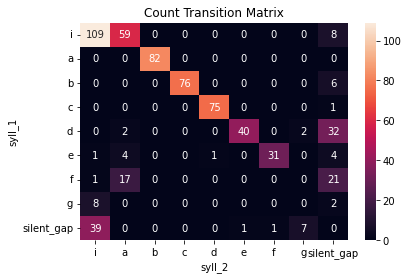

In [132]:
sns.heatmap(syntax_data.trans_mat, annot = True, fmt = '0.0f')
plt.title("Count Transition Matrix");

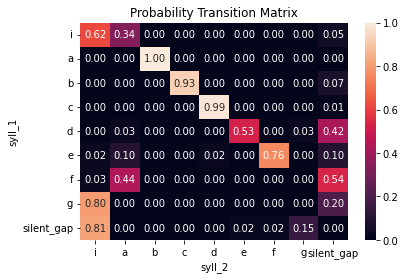

In [133]:
sns.heatmap(syntax_data.trans_mat_prob, annot = True, fmt = '0.2f')
plt.title("Probability Transition Matrix");

From these transition matrices, we can see that the bird has a very stereotyped song syntax, with each syllable in the core motif making one dominant, predictable transition to the next (with the exception of syllable 'd', which can sometimes transition to 'e' or mark the song bout). 

### Syntax Raster Plot

Like a transition matrix, a syntax raster plot can give us a strong overall impression of a bird's syntax. A syntax raster plot will present each song bout that the bird produces (ie a sequence of syllables flanked by long silent gaps or file boundaries) as a row in a heatmap, with the color of each cell reflecting the syllable label at that index. 

We can create a syntax raster dataframe for the subject bird with the method `.make_syntax_raster()` of our `syntax_data` object, and we can plot that resulting dataframe with the function `avn.plotting.plot_syntax_raster()`: 

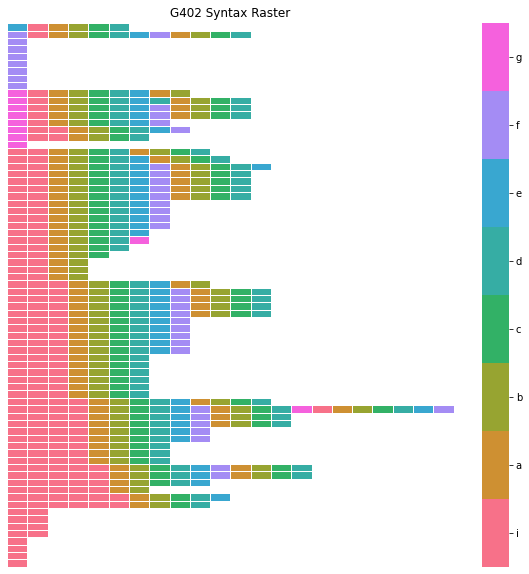

In [134]:
syntax_raster_df = syntax_data.make_syntax_raster()
plotting.plot_syntax_raster(syntax_data, syntax_raster_df, title= "G402 Syntax Raster")

To make it easier to detect patterns in the sequence of syllable, it can be useful to specify an 'alignment_syllable' when creating our syntax_raster_df. When an 'alignment_syllable' is provided as an argument to `.make_syntax_raster()` bouts will be shifted relative to one another so that the first occurance of the alignment syllable is at the same index for all bouts. When a bird has stereotyped syntax like this one, it is best set the alignment syllable to the first syllable of the motif, following intro notes. In this case, that is syllable 'a'. If the bird has more variable syntax, it can take some trial and error to identify the 'alignment_syllable' that works best. 

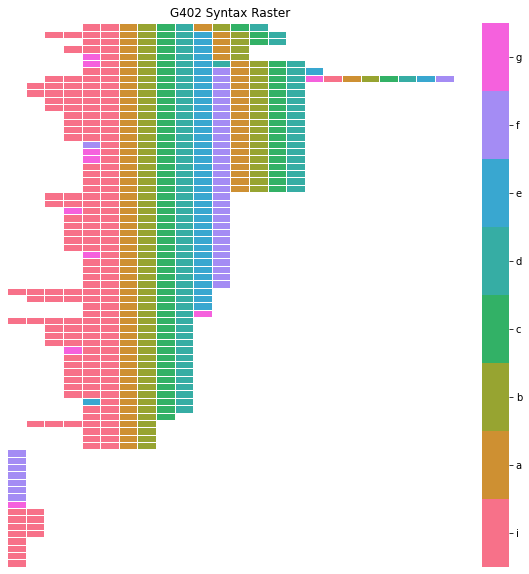

In [135]:
syntax_raster_df = syntax_data.make_syntax_raster(alignment_syllable='a')
plotting.plot_syntax_raster(syntax_data, syntax_raster_df, title = "G402 Syntax Raster")

By default, `.make_syntax_raster()` will sort the order of bouts, such that bouts with similar sequences of syllables occupy sequential rows in the plot. This is done to make it easier to see patterns in the order of syllables, but if you would prefer plotting bouts in the order that they occur in `.syll_df`, you can set the argument `sort_bouts=False` when calling `.make_syntax_raster()`. 

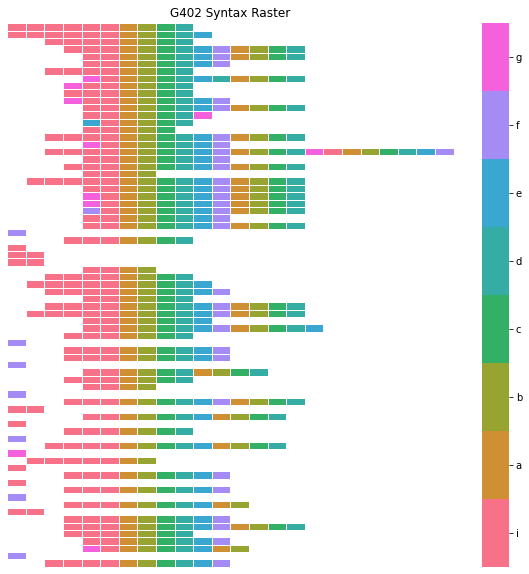

In [136]:
syntax_raster_df = syntax_data.make_syntax_raster(alignment_syllable='a', sort_bouts = False)
plotting.plot_syntax_raster(syntax_data, syntax_raster_df, title = "G402 Syntax Raster")

### Calculate Entropy Rate

While transition matrices and syntax raster plots are useful visualizations to get an impression of a bird's syntax, it can be useful to have a quantitiative measure of syntax variability, in order to make comparisons between birds or groups of birds. `avn` uses a metric called **Entropy Rate** as a global measure of syllable sequence predictability. 

$$ \text{entropy rate} = - \sum_{i, k} \pi_i p_{i,k} \log_2 (p_{i,k}) $$

where $p_{i,k}$ is the probability of transitioning from initial syllable type $i$ to following syllable type $k$, as in the probability transition matrix, and $\pi _i$ is the stationary  distribution of state $i$. Here, the stationary distribution is calculated emperically as  the probability of syllable type $i$ occuring, regarless of what syllable preceeds or follows it. 

An entropy rate of 0 indicates that all transitions are perfectly predictable. The maximum possible entropy rate value is $log_2 N$ where N is the number of possible states for $i$ or $k$. In our case, this is the number of unique syllable types produced by the bird + 1 for silent gaps. If you want to compare entropy rates across birds independent of the number of unique syllable types in that bird's repertoire, you can divide the entropy rate value by $log_2  N$. 

The entropy rate for a subject bird can be calculated by calling the `get_entropy_rate()` method of the `syntax_data` object. This requires that the `.trans_mat` and `.trans_mat_prob` attributes of `syntax_data` already be created by calling `.make_transition_matrix()`. 

In [137]:
entropy_rate = syntax_data.get_entropy_rate()
entropy_rate

0.7693101544402192

In [138]:
entropy_rate_norm = entropy_rate / np.log2(len(syntax_data.unique_labels) + 1)
entropy_rate_norm

0.2426903330804937

### Syllable Repetitions

Beyond looking at overall syntax variability/entropy, it can be interesting to look at whether birds repeat the same syllable many times. In terms of the transition matrix, repetition manifests as a change in only one transition (the transition from the repeated syllable to itself), and therefor has a small impact on entropy rate. As a result, we need special approaches to identify birds with abnormal syllable repetitions. 

One approach is to look at the probability of transition to self for every syllable type (ie the probability that syllable 'a' transitions to 'a', 'b' to 'b', etc.). We can quickly get these values from the transition probability matrix using the `.get_prob_repetition()` method of our `syntax_data` object. 

In [139]:
prob_repetitions = syntax_data.get_prob_repetitions()
prob_repetitions

,Bird_ID,syllable,prob_repetition
0,G402,i,0.619318
0,G402,a,0.000000
0,G402,b,0.000000
0,G402,c,0.000000
0,G402,d,0.000000
0,G402,e,0.000000
0,G402,f,0.000000
0,G402,g,0.000000
0,G402,silent_gap,0.000000


From this, we can see that syllable 'i' has a very high probability of repeating itself. This makes sense as we know that  'i' is an introductory note.

This doesn't give us a full impression of the repetition patterns, however. The prob_repetition of 'i' could indicate that the syllable always repeats itself ~3 times in a row, or it could sometimes be produced without repeating, and sometimes be repeated many times in a row. To get at this question, we can call the `.get_single_repetition_stats()` method of our `syntax_data` object, which returns 2 dataframes:  `single_rep_counts` and `single_rep_stats`. 

In [140]:
single_rep_counts, single_rep_stats = syntax_data.get_single_repetition_stats()

`single_rep_counts` is a dataframe containing the number of times that each syllable occurs in a repetition bout of a given duration. In the example below, we can see that syllable 'i' is only produced singly (ie preceeded and followed by syllables types other than 'i') 12 times. It is repeated twice in a row 24 times, 3 times in a row 16 times etc. 

In [141]:
single_rep_counts

,1,syllable,2,3,4,5,6,Bird_ID
0,12,i,24.0,16.0,9.0,4.0,2.0,G402
0,82,a,0.0,0.0,0.0,0.0,0.0,G402
0,82,b,0.0,0.0,0.0,0.0,0.0,G402
0,76,c,0.0,0.0,0.0,0.0,0.0,G402
0,76,d,0.0,0.0,0.0,0.0,0.0,G402
0,41,e,0.0,0.0,0.0,0.0,0.0,G402
0,39,f,0.0,0.0,0.0,0.0,0.0,G402
0,10,g,0.0,0.0,0.0,0.0,0.0,G402


`single_rep_stats` contains summary statistics about the repetition bout durations for each syllable type. In the example below, we can see that syllable 'i' occurs  in a mean_repetition bout length of between 2 and 3 times in a row. Because the duration of the repetition bouts in which it is produced are so variable, it has a high coefficient of variation of repetition bout length.

In [142]:
single_rep_stats

,syllable,mean_repetition_length,median_repetition_length,CV_repetition_length,Bird_ID
0,i,2.626866,2.0,0.478084,G402
0,a,1.000000,1.0,0.000000,G402
0,b,1.000000,1.0,0.000000,G402
0,c,1.000000,1.0,0.000000,G402
0,d,1.000000,1.0,0.000000,G402
0,e,1.000000,1.0,0.000000,G402
0,f,1.000000,1.0,0.000000,G402
0,g,1.000000,1.0,0.000000,G402


### Identifying Intro Notes and Calls

Given that these syllable labels were generated by hand labeling spectrograms, we know *a priori* that syllable 'i' is an introductory note, and therefore that its high rate of repetition is not abnormal for a zebra finch. However, if we generate syllable labels automatically and are trying to identify birds with abnormal syllable repetitions, it would be important to know which syllable labels likely reflect introductory notes (or calls, which are also sometimes repeated multiple times in short succession), and which do not. Thankfully, our `syntax_data` object also has some methods to make this easier. 



#### Identifying Intro Notes

Because we want to be able to detect possible introductory notes even in birds with very variable motif syntax, we need to keep our defenition of an intro note very broad. We consider that a syllable type is a candidate intro note if: 

1. The syllable is among the most common syllable types transitioned to from a silent gap
2. The syllable makes one dominant transition (other than to itself) to a syllable type that is not a silent gap. 

Calling the `.get_intro_notes_df()` method of our `syntax_data` object will generate a dataframe with a column of boolean values to indicate whether each syllable type meets these intro note criteria. 

In [143]:
intro_notes_df = syntax_data.get_intro_notes_df()
intro_notes_df

,syllable,Bird_ID,intro_note
0,i,G402,True
0,a,G402,False
0,b,G402,False
0,c,G402,False
0,d,G402,False
0,e,G402,False
0,f,G402,False
0,g,G402,False


We can see that, indeed, syllable 'i' met the criteria to be considered an intro note, and no other syllables met this definition. This method is quite reliable for identifying intro notes but, particularly in the case of birds with very variable syntax, it can be useful to examine the spectrogram with labels to see whether the syllable actually resembles an intro note. The function `plotting.plot_spectrogram_with_labels()` can be used to plot the spectrogram of a file with syllable labels overlaid. 

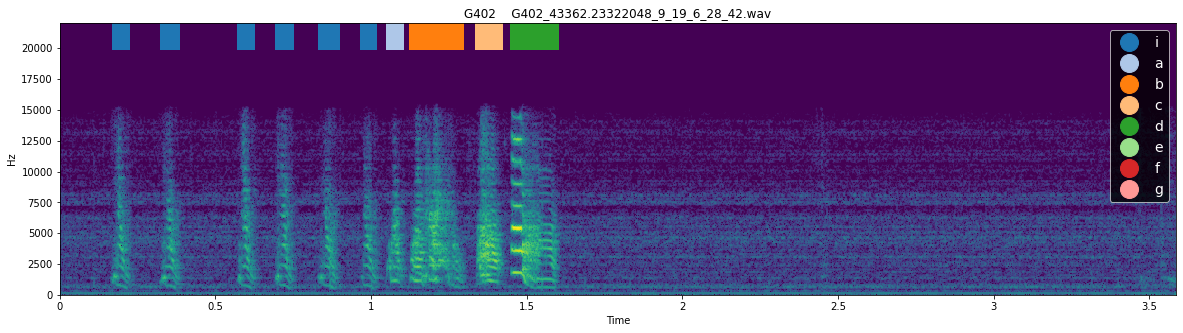

<Figure size 1440x360 with 0 Axes>

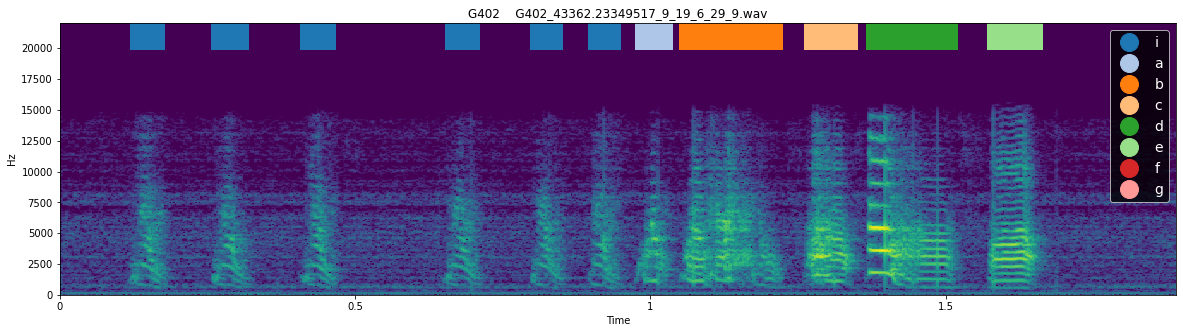

<Figure size 1440x360 with 0 Axes>

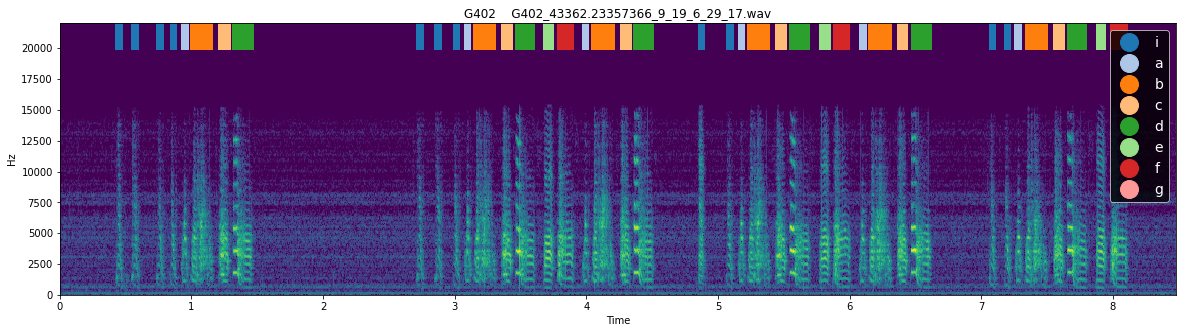

<Figure size 1440x360 with 0 Axes>

In [156]:
for i in range(3):
    plotting.plot_spectrogram_with_labels(syll_df, "../sample_data/",  Bird_ID, song_file_index= i, figsize = (20, 5), fontsize= 14)

#### Identifying Calls

When looking for abnormally repeated song syllables, it can also be important to distinguish between syllable types that reflect song syllables, and syllable types that reflect calls. The `.calc_prop_syll_in_short_bouts()` method of the `syntax_data` object can be used to do this. It will return a dataframe with a row for each syllable, with columns `full_count` containing the number of times that syllable type occurs in total in `.syll_df`, `short_bout_count` containing the number times that syllable type occurs in a bout of length 1 or 2 (ie only one or two syllables in a row flanked by silent gaps), and `prop_short_bout` containing the proportion of occurances of the syllable type in short bouts (< 2). If syllables occur with a high proportion in these short bouts, there is a good chance that they reflect calls. 

A maximum 'short bout' length of 2 syllables is the default for this function, but you can change the number of syllables required for a bout to be considered 'short' by setting the `max_short_bout_len` argument to `.get_prop_sylls_in_short_bouts()`. 

In [153]:
prop_sylls_in_short_bouts = syntax_data.get_prop_sylls_in_short_bouts(max_short_bout_len=2)
prop_sylls_in_short_bouts

,syllable,full_count,short_bout_count,Bird_ID,prop_short_bout
0,a,82,0.0,G402,0.000000
1,b,82,0.0,G402,0.000000
2,c,76,0.0,G402,0.000000
3,d,76,0.0,G402,0.000000
4,e,41,0.0,G402,0.000000
5,f,40,8.0,G402,0.200000
8,g,18,9.0,G402,0.500000
9,i,179,15.0,G402,0.083799


Here, we can see that syllable 'g' is commonly produced in short bouts, and thus is likely to reflect a call rather than a song syllable. As with intro notes, it is best to confirm this by examining example spectrograms containing the syllable: 

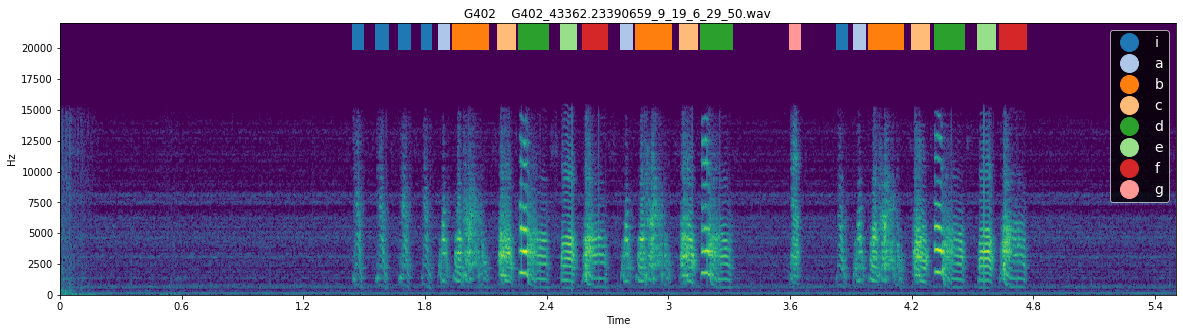

<Figure size 1440x360 with 0 Axes>

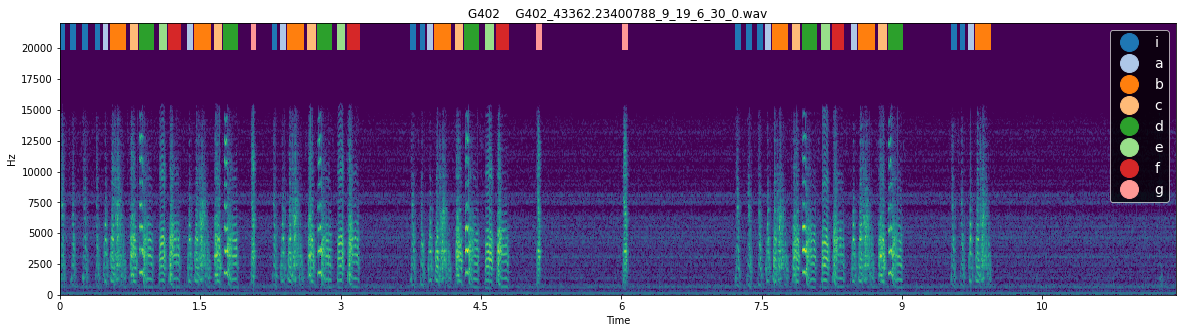

<Figure size 1440x360 with 0 Axes>

In [157]:
for i in [4, 5]:
    plotting.plot_spectrogram_with_labels(syll_df, "../sample_data/",  Bird_ID, song_file_index= i, figsize = (20, 5), fontsize= 14)

Indeed, when we look at these example spectrograms, syllable 'g' does appear to be a call produced between but not within song bouts. 

#### Merging syll stats

`avn.syntax.Utils` contains a useful function for combining repetition, intro note and short bout proportion information across syllable types. Passing these 3 dataframes to `syntax.Utils.merge_per_syll_stats()` will create a single dataframe with columns from all 3 dataframes merged. The result can be useful for filtering for syllable types that have high repetition rates without being intro notes or calls. 

In [158]:
per_syll_stats = syntax.Utils.merge_per_syll_stats(single_rep_stats, prop_sylls_in_short_bouts, intro_notes_df)
per_syll_stats

,syllable,mean_repetition_length,median_repetition_length,CV_repetition_length,Bird_ID,full_count,short_bout_count,prop_short_bout,intro_note
0,i,2.626866,2.0,0.478084,G402,179,15.0,0.083799,True
1,a,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False
2,b,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False
3,c,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False
4,d,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False
5,e,1.000000,1.0,0.000000,G402,41,0.0,0.000000,False
6,f,1.000000,1.0,0.000000,G402,40,8.0,0.200000,False
7,g,1.000000,1.0,0.000000,G402,18,9.0,0.500000,False


### Syllable Pair Repetition

Just as it can be interesting to look at repetitions of a single syllable in a row, it might be of interest to see if a bird produces a pair of syllables in a row, ie a pair of syllables in alternation many times. Our `syntax_data` object has a method analogous to `get_single_repetition_stats()`- which we saw in the 'Syllable Repetition' section of this notebook - called `get_pair_repetition_stats()`. 

Like `get_single_repetition_stats()`, `get_pair_repetition_stats()` returns 2 dataframes: `pair_rep_counts`  and `pair_rep_stats`. 

In [159]:
pair_rep_counts, pair_rep_stats  = syntax_data.get_pair_repetition_stats()

`pair_rep_counts` contains one row for every pair of syllables that occur together in `.syll_df`. This bird has no repeated syllable pairs so the value in all columns reflecting repetions more than once in a row are 0, but for example if the bird sang 'ababab', syllable 'a_b' would be repeated 3 times and thus have a value of 1 in the 3 column. 

In [161]:
pair_rep_counts

,1,syllable,2,3,Bird_ID,first_syll,second_syll
0,59,i_a,0.0,0.0,G402,i,a
0,76,b_c,0.0,0.0,G402,b,c
0,82,a_b,0.0,0.0,G402,a,b
0,75,c_d,0.0,0.0,G402,c,d
0,40,d_e,0.0,0.0,G402,d,e
0,17,f_a,0.0,0.0,G402,f,a
0,31,e_f,0.0,0.0,G402,e,f
0,2,d_a,0.0,0.0,G402,d,a
0,8,g_i,0.0,0.0,G402,g,i
0,2,d_g,0.0,0.0,G402,d,g


`pair_rep_stats` contains summary statistics about the length of repetition bouts of pairs of syllables. 

In [162]:
pair_rep_stats

,syllable,mean_repetition_length,median_repetition_length,CV_repetition_length,Bird_ID,first_syll,second_syll
0,i_a,1.0,1.0,0.0,G402,i,a
0,b_c,1.0,1.0,0.0,G402,b,c
0,a_b,1.0,1.0,0.0,G402,a,b
0,c_d,1.0,1.0,0.0,G402,c,d
0,d_e,1.0,1.0,0.0,G402,d,e
0,f_a,1.0,1.0,0.0,G402,f,a
0,e_f,1.0,1.0,0.0,G402,e,f
0,d_a,1.0,1.0,0.0,G402,d,a
0,g_i,1.0,1.0,0.0,G402,g,i
0,d_g,1.0,1.0,0.0,G402,d,g


### Saving Output

Once you've run all these methods on `syntax_data`, you may want to save the updated `.syll_df` attribute, as well as the transition matrices. This can be done by calling the `.save_syntax_data()` method of your `syntax_data` object which takes as input the path to the folder in which you want to save the data. 

It will save a copy of the current `.syll_df` attribute as a file entitled '[Bird_ID]_syll_df.csv', `.trans_mat` as '[Bird_ID]_trans_mat.csv', `.trans_mat_prob` as '[Bird_ID]_trans_mat_prob.csv', and a newly created `syntax_analysis_metadata` dataframe as '[Bird_ID]_syntax_analysis_metadata.csv' to the specified output folder. It will also return the `syntax_analysis_metadata` object for you to review right away. 

In [163]:
syntax_analysis_metadata = syntax_data.save_syntax_data("../sample_data/G402_syntax_analysis/")
syntax_analysis_metadata

,Date,avn_version,syll_df_path,file_boundaries_added,gaps_added,min_gap,calls_dropped,transition_matrices_saved,trans_mat_path,trans_mat_prob_path
0,2021-11-05,0.2.1,../sample_data/G402_syntax_analysis/G402_syll_...,True,True,0.2,True,True,../sample_data/G402_syntax_analysis/G402_trans...,../sample_data/G402_syntax_analysis/G402_trans...


## Syntax Analysis for Many Birds

### Required Data Organization

If you have many birds whose syntax you want to analyse at once and whose data you want to compile into global tables, the `avn.syntax.Utils` models contains a number of functions for that purpose. To use these functions, you must have your song data organized such that a main folder `song_folder_path` contains subfolders named with the Bird_ID of each bird you want to analysed, where the subfolders contain the song .wav files for each bird. You also need to specify a  `syll_df_folder_path`, which is a folder containing syll_df files of the type described in the 'Creating a SyntaxData Object' section above that are named according to the convention 'Bird_ID_syll_df_file_name_suffix'. 

In my case, all syll_df files are located in "../sample_data/", and they are named "[Bird_ID]_syll_df.csv". Subfolders with song data named for each bird are also located in "../sample_data/". 

### Make Transition Matrices

You can plot the transition matrix for all birds in the list `Bird_IDs` with the function `syntax.Utils.plot_transition_matrix_all_birds()`. 

This function takes a number of optional arguments which allow you to customize the resulting plots. These can be reviewed in the documentation for the function. 

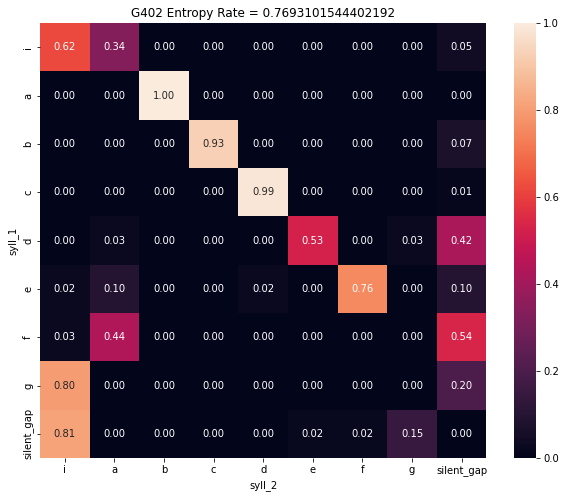

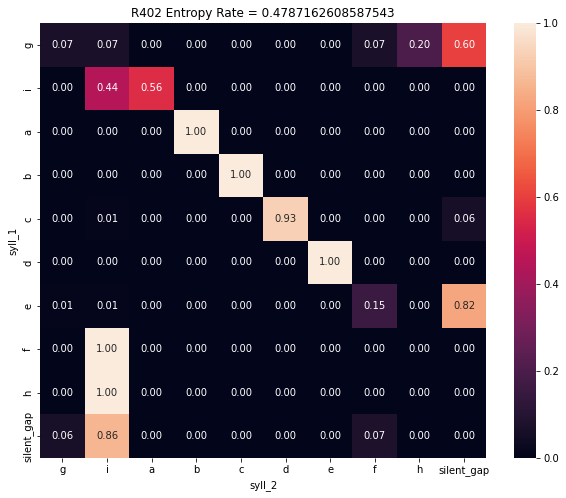

In [166]:
Bird_IDs = ['G402', 'R402']

syntax.Utils.plot_transition_matrix_all_birds(Bird_IDs = Bird_IDs, 
                                              syll_df_folder_path = "../sample_data/", 
                                              syll_df_file_name_suffix = '_syll_df.csv', 
                                              song_folder_path = "../sample_data/")

### Syntax Raster Plot

You can plot the syntax raster plot for each bird in Bird_IDs with the function `syntax.Utils.plot_syntax_raster_all_birds()`. 

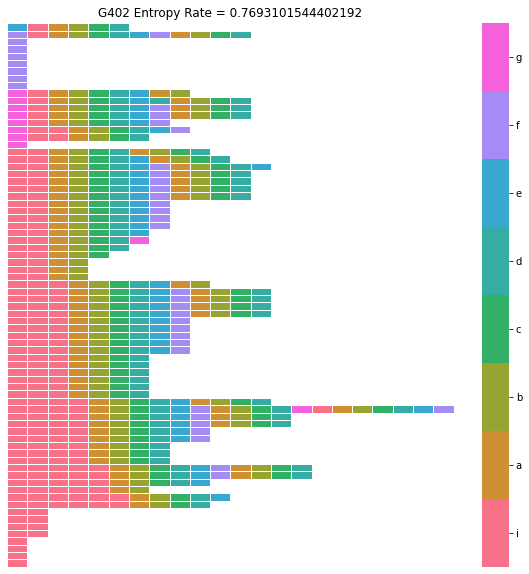

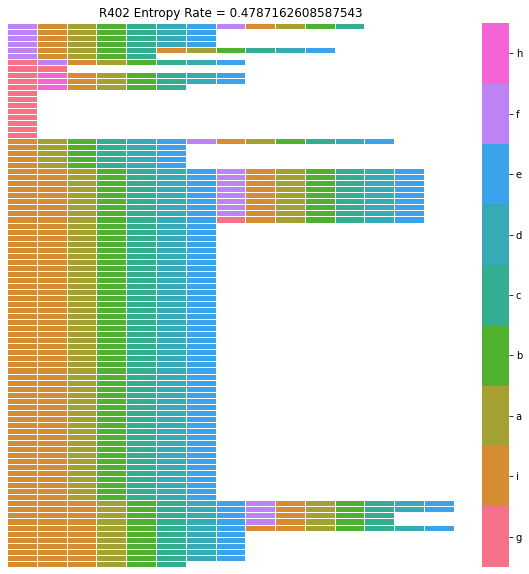

In [168]:
Bird_IDs = ['G402', 'R402']

syntax.Utils.plot_syntax_raster_all_birds(Bird_IDs = Bird_IDs,
                                          syll_df_folder_path = "../sample_data/", 
                                          syll_df_file_name_suffix = '_syll_df.csv', 
                                          song_folder_path = "../sample_data/")

For more information on syntax raster plots, refer to the section 'Syntax Analysis for a Single Bird / Syntax Raster Plot' above in this notebook. 

### Calculate Entropy Rate

You can calculate the entropy rate for all birds in Bird_IDs and compile them into a single dataframe with the function `syntax.Utils.calc_entropy_rate_all_birds()`. 

In [167]:

all_entropy_rates = syntax.Utils.calc_entropy_rate_all_birds(Bird_IDs = Bird_IDs, 
                                                             syll_df_folder_path = "../sample_data/",
                                                             syll_df_file_name_suffix = '_syll_df.csv',
                                                             song_folder_path = "../sample_data/")
all_entropy_rates

,Bird_ID,entropy_rate,num_unique_syll_types,entropy_rate_norm
0,G402,0.769310,9,0.242690
0,R402,0.478716,10,0.144108


The column `entropy_rate` contains the unnormalized entropy rate value for each bird. `entropy_rate_norm` contains an entropy rate values that is normalized according to the number of unique syllables types in the bird's song. For more information on entropy rate, refer to the section 'Syntax Analysis for a Single Bird / Calculate Entropy Rate' above in this notebook. 

### Identifying Abnormal Syllables

You can compile repetition statistics, short bout proportions, and intro note statuses for each syllable type across birds in Bird_IDs into a single dataframe with the function `syntax.Utils.get_syll_stats_all_birds()`.

In [170]:
Bird_IDs = ['G402', 'R402']

syll_stats_all_birds = syntax.Utils.get_syll_stats_all_birds(Bird_IDs = Bird_IDs, 
                                                             syll_df_folder_path = "../sample_data/", 
                                                             syll_df_file_name_suffix = '_syll_df.csv', 
                                                             song_folder_path = "../sample_data/")
syll_stats_all_birds

,syllable,mean_repetition_length,median_repetition_length,CV_repetition_length,Bird_ID,full_count,short_bout_count,prop_short_bout,intro_note
0,i,2.626866,2.0,0.478084,G402,179,15.0,0.083799,True
1,a,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False
2,b,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False
3,c,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False
4,d,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False
5,e,1.000000,1.0,0.000000,G402,41,0.0,0.000000,False
6,f,1.000000,1.0,0.000000,G402,40,8.0,0.200000,False
7,g,1.000000,1.0,0.000000,G402,18,9.0,0.500000,False
0,i,1.795918,2.0,0.346358,R402,180,4.0,0.022222,True
1,a,1.000000,1.0,0.000000,R402,98,0.0,0.000000,False


This dataframe can be very useful for identifying syllables with abnormal repetition patterns. In fact, `syntax.Utils` has another function to do just that.

`syntax.Utils.identify_abnormal_syllables()` takes a dataframe of the type returned above as input, and it identifies syllables that are over `std_cutoff` standard deviations from the mean in terms of `mean_repetition_length` or `CV_repeition_length`. It will return a dataframe simlar to `syll_stats_all_birds`, but with the additional column `abnormal_repetition` containing a boolean value to indicate whetehr that syllable exhibits unusually high repetition or repetition variability. 

The default value of `std_cutoff` is 2, meaning that a syllable must be 2 or more standard deviations from the mean in order to be considered 'abnormal', but this value can be changed by passing it as an argument to `identify_abnormal_syllables()`. 

This function also takes 2 optional booleans as input: `exclude_intro_notes` and `exclude_calls`. By default these are both set to True. When `exclude_intro_notes` is True, syllables with True in the `intro_note` column of `syll_stats_all_birds` will not be considered when calculating the mean and std of repetition stats used to identify abnormal syllables. Additionally, these none of these intro notes will be identified as 'abnormal'. If it is False, then these syllables will be treated like any other syllable type in `syll_stats_all_birds`. 

When `exclude_calls` is True, syllables which occur in short bouts greater than `prop_short_bout_cutoff` propotion of the time will be considered calls, and will not be considered when calculating the mean and std of repetitions stats used to identify abnormal syllables. Additionally, non of these calls will be identified as 'abnormal'. The default value of `prop_short_bout_cutoff` is 0.5, meaning a syllable must be produced in a short bout more than half the time to be considered a call, but this value can also be set manually by passing it as an optional argument to the function. 

**Note**: This generally works best when analyzing a larger set of birds. As I am only looking at 2 birds here, both of which have very stereotyped syntax, I'm  going to include calls and intro notes in the abnormal syllable identification process, just so that we have at least one syllable identified as 'abnormal'. 

In [172]:
syll_stats_all_birds = syntax.Utils.identify_abnormal_syllables(syll_stats_all_birds= syll_stats_all_birds, 
                                                                std_cutoff = 2, 
                                                                exclude_calls = False, 
                                                                exclude_intro_notes = False)

syll_stats_all_birds

,syllable,mean_repetition_length,median_repetition_length,CV_repetition_length,Bird_ID,full_count,short_bout_count,prop_short_bout,intro_note,abnormal_repetition
0,i,2.626866,2.0,0.478084,G402,179,15.0,0.083799,True,True
1,a,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False,False
2,b,1.000000,1.0,0.000000,G402,82,0.0,0.000000,False,False
3,c,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False,False
4,d,1.000000,1.0,0.000000,G402,76,0.0,0.000000,False,False
5,e,1.000000,1.0,0.000000,G402,41,0.0,0.000000,False,False
6,f,1.000000,1.0,0.000000,G402,40,8.0,0.200000,False,False
7,g,1.000000,1.0,0.000000,G402,18,9.0,0.500000,False,False
0,i,1.795918,2.0,0.346358,R402,180,4.0,0.022222,True,False
1,a,1.000000,1.0,0.000000,R402,98,0.0,0.000000,False,False
